# Homework goals: Training neural networks
- Get comfortable practicing backprop
- Investigate the effect of different optimizers
- Implement different initializers and see their effects on deep networks
- Learn how to implement the components using PyTorch

## Question 1: warmup on a scalar network
We are going to revisit the scalar network we implemented previously and implement backprop for it. Then, we're going to generalize it to a much deeper network so that your implementation can't rely on hardcoding without making yourself miserable.
$$f[x;\phi] = \beta_3 + \omega_3 \cdot \cos \left[\beta_2 + \omega_2 \cdot \exp \left[\beta_1 + \omega_1 \cdot \sin \left[\beta_0 + \omega_0 \cdot x] \right] \right] \right]$$
First, what does this function look like for some random values of the parameters? Let's plot it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
set_seed(0)

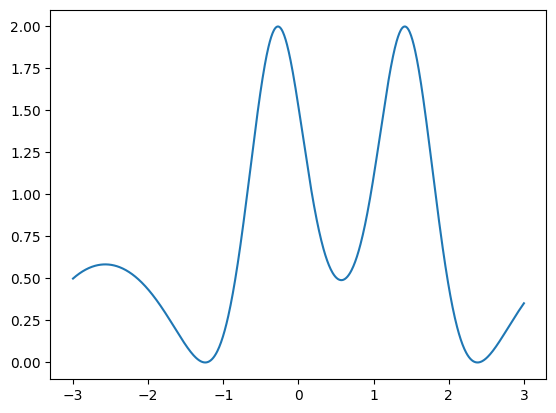

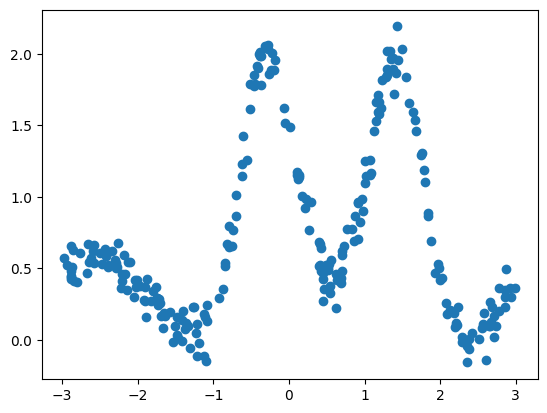

In [2]:
omega_0 = 1.0
beta_0 = 1.0
omega_1 = 1.0
beta_1 = 1.0
omega_2 = 1.0
beta_2 = 1.0
omega_3 = 1.0
beta_3 = 1.0
# $$f[x;\phi] = \beta_3 + \omega_3 \cdot \cos \left[\beta_2 + \omega_2 \cdot \exp \left[\beta_1 + \omega_1 \cdot \sin \left[\beta_0 + \omega_0 \cdot x] \right] \right] \right]$$
def f(x, omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3):
    return beta_3 + omega_3 * np.cos(beta_2 + omega_2 * np.exp(beta_1 + omega_1 * np.sin(beta_0 + omega_0 * x)))

x_range = np.linspace(-3, 3, 1000)
plt.figure()
plt.plot(x_range, f(x_range, omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3))

# Lets generate a dataset for this and try to fit it with this function
# Lets just make it some random polynomial
data_size = 256
x_data = np.random.uniform(-3, 3, data_size)
y_data = f(x_data, omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3) + np.random.normal(0, 0.1, data_size)
# plot it real quick
plt.figure()
plt.scatter(x_data, y_data)

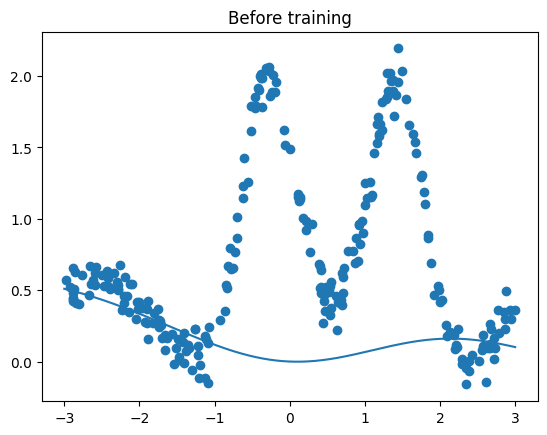

Loss at iteration 0: 0.7690380867591341
Loss at iteration 100: 0.37392397184976167
Loss at iteration 200: 0.2692940421899598
Loss at iteration 300: 0.08208879212097123
Loss at iteration 400: 0.03125235117714871
Loss at iteration 500: 0.01752465119688109
Loss at iteration 600: 0.012931707957815973
Loss at iteration 700: 0.011144834041764268
Loss at iteration 800: 0.01031062404370904
Loss at iteration 900: 0.00984544334704947


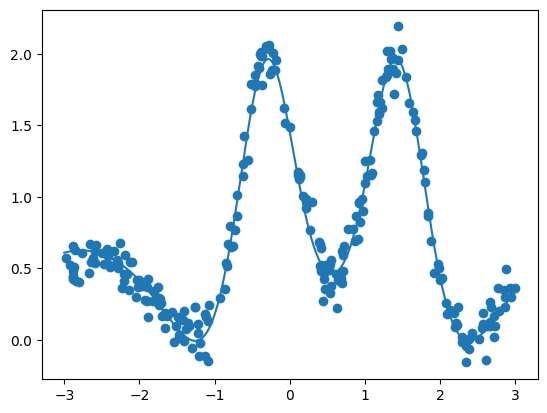

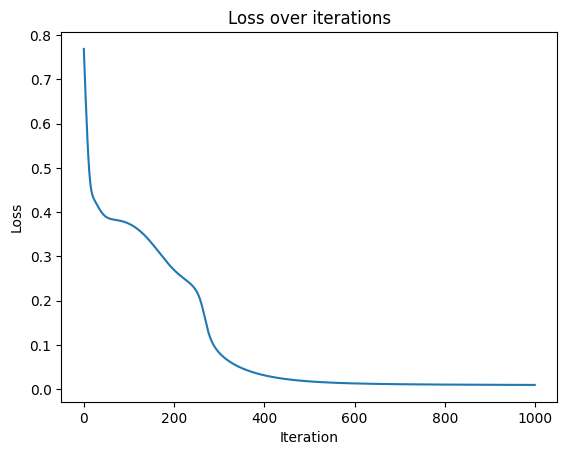

In [3]:
class ScalarFunction():
    def __init__(self, omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3, learning_rate):
        self.omega_0 = omega_0
        self.beta_0 = beta_0
        self.omega_1 = omega_1
        self.beta_1 = beta_1
        self.omega_2 = omega_2
        self.beta_2 = beta_2
        self.omega_3 = omega_3
        self.beta_3 = beta_3
        self.learning_rate = learning_rate

    # Now lets implement backpropagation
    def compute_gradients(self, x_data, y_data):
        # TODO: this function should return the values of omega_0, beta_0, etc.
        # Forward pass
        z_0 = self.beta_0 + self.omega_0 * x_data
        z_1 = self.beta_1 + self.omega_1 * np.sin(z_0)
        z_2 = self.beta_2 + self.omega_2 * np.exp(z_1)
        y_pred = self.beta_3 + self.omega_3 * np.cos(z_2)
        # Backward pass
        dL_dy_pred = 2 * (y_pred - y_data)
        dL_domega_3 = np.mean(dL_dy_pred * np.cos(z_2))
        dL_dbeta_3 = np.mean(dL_dy_pred)
        dL_dz_2 = dL_dy_pred * -self.omega_3 * np.sin(z_2)
        dL_domega_2 = np.mean(dL_dz_2 * np.exp(z_1))
        dL_dbeta_2 = np.mean(dL_dz_2)
        dL_dz_1 = dL_dz_2 * self.omega_2 * np.exp(z_1)
        dL_domega_1 = np.mean(dL_dz_1 * np.cos(z_0))
        dL_dbeta_1 = np.mean(dL_dz_1)
        dL_dz_0 = dL_dz_1 * self.omega_1 * np.cos(z_0)
        dL_domega_0 = np.mean(dL_dz_0 * x_data)
        dL_dbeta_0 = np.mean(dL_dz_0)
        return dL_domega_0, dL_dbeta_0, dL_domega_1, dL_dbeta_1, dL_domega_2, dL_dbeta_2, dL_domega_3, dL_dbeta_3

    def apply_gradients(self, dL_domega_0, dL_dbeta_0, dL_domega_1, dL_dbeta_1, dL_domega_2, dL_dbeta_2, dL_domega_3, dL_dbeta_3, learning_rate):
        # TODO fill this in
        # This function should return the updated values of omega_0, beta_0, etc.
        self.omega_0 -= self.learning_rate * dL_domega_0
        self.beta_0 -= self.learning_rate * dL_dbeta_0
        self.omega_1 -= self.learning_rate * dL_domega_1
        self.beta_1 -= self.learning_rate * dL_dbeta_1
        self.omega_2 -= self.learning_rate * dL_domega_2
        self.beta_2 -= self.learning_rate * dL_dbeta_2
        self.omega_3 -= self.learning_rate * dL_domega_3
        self.beta_3 -= self.learning_rate * dL_dbeta_3

    def update(self, x_data, y_data):
        dL_domega_0, dL_dbeta_0, dL_domega_1, dL_dbeta_1, dL_domega_2, dL_dbeta_2, dL_domega_3, dL_dbeta_3 = self.compute_gradients(x_data, y_data)
        self.apply_gradients(dL_domega_0, dL_dbeta_0, dL_domega_1, dL_dbeta_1, dL_domega_2, dL_dbeta_2, dL_domega_3, dL_dbeta_3, learning_rate)
        
    def forward(self, x_data):
        return f(x_data, self.omega_0, self.beta_0, self.omega_1, self.beta_1, self.omega_2, self.beta_2, self.omega_3, self.beta_3)
    
    def loss(self, x_data, y_true):
        return np.mean((self.forward(x_data) - y_true)**2)

# Now lets train the model
omega_0 = 0.5
beta_0 = 0.5
omega_1 = 0.5
beta_1 = 0.5
omega_2 = 1.0
beta_2 = 1.0
omega_3 = 1.0
beta_3 = 1.0
learning_rate = 0.01

func = ScalarFunction(omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3, learning_rate)

def plot_and_run(func, num_iters, selection_fn):
    # lets quickly plot what this looks like before it all gets started
    y_pred = func.forward(x_range)
    plt.figure()
    plt.plot(x_range, y_pred)
    plt.scatter(x_data, y_data)
    plt.title('Before training')
    plt.show()

    # Okay now lets run gradient descent and periodically store the loss for plotting later
    losses = []
    for i in range(num_iters):
        func.update(*selection_fn(x_data, y_data))
        losses.append(func.loss(x_data, y_data))
        if i % 100 == 0:
            print(f'Loss at iteration {i}: {losses[-1]}')

    # plot the predictions at the end of training
    y_pred = func.forward(x_range)
    plt.figure()
    plt.plot(x_range, y_pred)
    plt.scatter(x_data, y_data)

    # plot the loss functions
    plt.figure()
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss over iterations')

def selection_fn(x_data, y_data):
    # This function is used to select the data points to use for training
    return x_data, y_data

plot_and_run(func, 1000, selection_fn)

## Now lets see something pretty interesting. Lets try this again but in a setting with different initializations.

This will show you some of the challenges that can show up when we're working with very non-convex functions


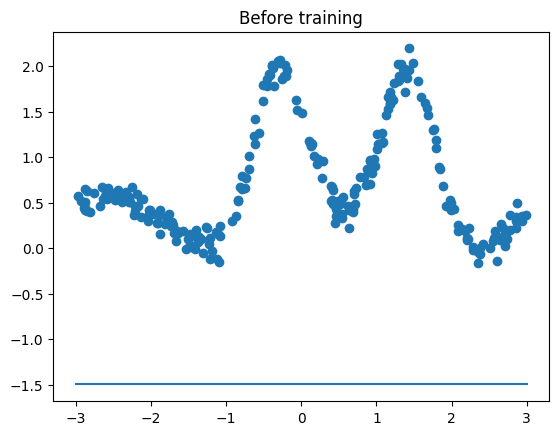

Loss at iteration 0: 4.963115243046651
Loss at iteration 100: 0.3879777631727639
Loss at iteration 200: 0.3866694587247385
Loss at iteration 300: 0.3866690528012118
Loss at iteration 400: 0.3866690203258056
Loss at iteration 500: 0.38666898800509647
Loss at iteration 600: 0.38666895573212634
Loss at iteration 700: 0.38666892350646265
Loss at iteration 800: 0.3866688913277039
Loss at iteration 900: 0.38666885919544985


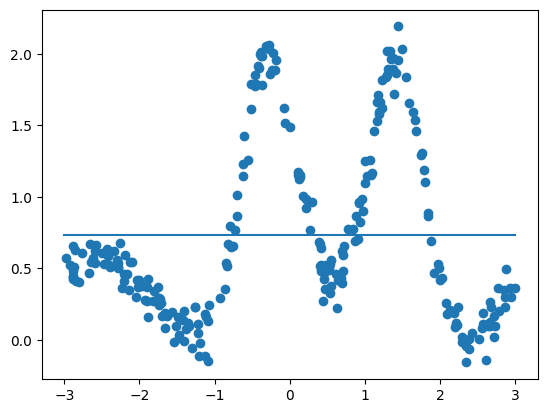

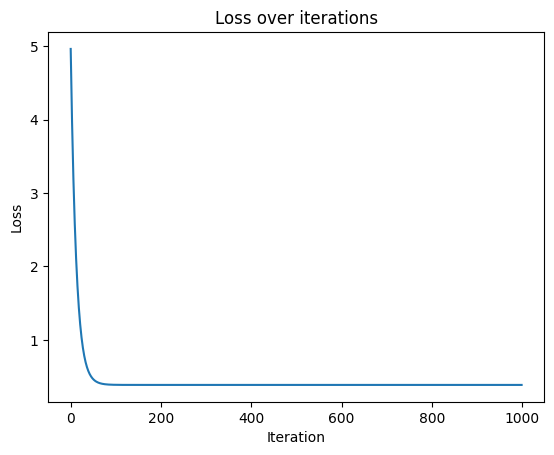

In [4]:
# Lets draw our initializations from a Gaussian distribution
omega_0 = np.random.normal(0, 1)
beta_0 = np.random.normal(0, 1)
omega_1 = np.random.normal(0, 1)
beta_1 = np.random.normal(0, 1)
omega_2 = np.random.normal(0, 1)
beta_2 = np.random.normal(0, 1)
omega_3 = np.random.normal(0, 1)
beta_3 = np.random.normal(0, 1)
learning_rate = 0.01
func = ScalarFunction(omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3, learning_rate)
plot_and_run(func, 1000, selection_fn)

## 1.2 Nothing to do here, just interesting.
So what's happening here? Well, it looks like we're trapped in a local minimum. One way to see this is to plot the loss as a function of the parameters. This is hard to visualize in higher dimension, so let's just plot it in 2D for one set of parameters. We'll take the function we just constructed and sweep the value of $\omega_0$ and see how it changes. 

Text(0.5, 1.0, 'Loss as a function of omega_0')

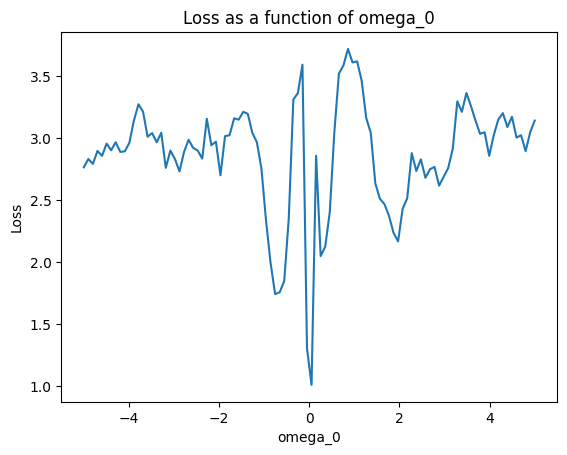

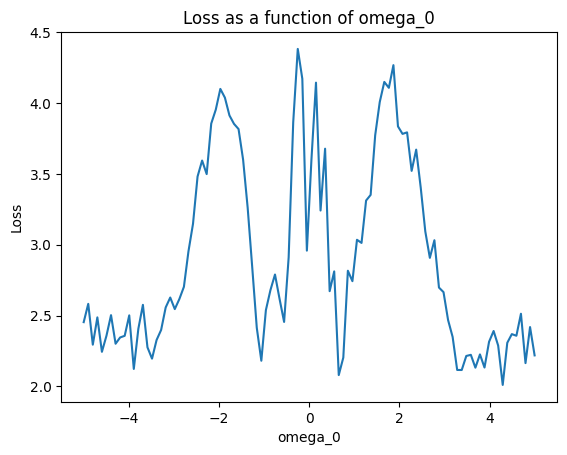

In [5]:
omega_0 = np.random.normal(0, 1)
beta_0 = np.random.normal(0, 1)
omega_1 = np.random.normal(0, 1)
beta_1 = np.random.normal(0, 1)
omega_2 = np.random.normal(0, 1)
beta_2 = np.random.normal(0, 1)
omega_3 = np.random.normal(0, 1)
beta_3 = np.random.normal(0, 1)
learning_rate = 0.01
func = ScalarFunction(omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3, learning_rate)

omega_0_range = np.linspace(-5, 5, 100)
losses = []
original_value = func.omega_0
for val in omega_0_range:
    func.omega_0 = val
    losses.append(func.loss(x_data, y_data))
func.omega_0 = original_value
plt.figure()
plt.plot(omega_0_range, losses)
plt.xlabel('omega_0')
plt.ylabel('Loss')
plt.title('Loss as a function of omega_0')

# Lets try the same thing for omega 1
original_value = func.omega_1
losses = []
for val in omega_0_range:
    func.omega_1 = val
    losses.append(func.loss(x_data, y_data))
func.omega_1 = original_value
plt.figure()
plt.plot(omega_0_range, losses)
plt.xlabel('omega_0')
plt.ylabel('Loss')
plt.title('Loss as a function of omega_0')


So if we just follow the gradient, we're almost certainly going to get trapped in a local minimum. The point of this is just to recognize that there are going to be non-convex functions that are pretty hard to optimize! We're fortunate that it appears that neural networks do not fall into this class.

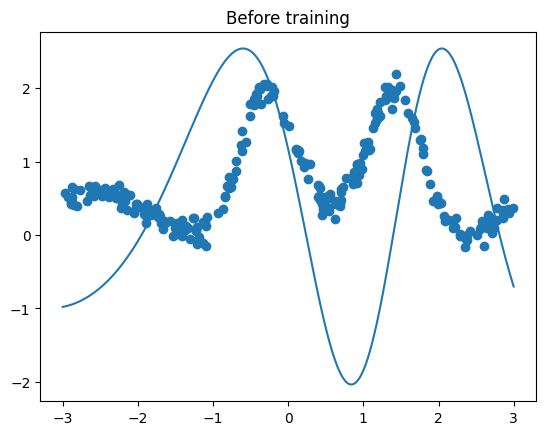

Loss at iteration 0: 2.1569113870701853
Loss at iteration 100: 0.27050790379937734
Loss at iteration 200: 0.2641651243529207
Loss at iteration 300: 0.2604336788685948
Loss at iteration 400: 0.25892975439101606
Loss at iteration 500: 0.2585110176098226
Loss at iteration 600: 0.2660418885496234
Loss at iteration 700: 0.2583747813368755
Loss at iteration 800: 0.2585246847850179
Loss at iteration 900: 0.2587437208322781
Loss at iteration 1000: 0.27205934223219297
Loss at iteration 1100: 0.25807768324658154
Loss at iteration 1200: 0.2673004356847553
Loss at iteration 1300: 0.25963982066062147
Loss at iteration 1400: 0.2577701286153279
Loss at iteration 1500: 0.25839322037447066
Loss at iteration 1600: 0.2596176549506823
Loss at iteration 1700: 0.2575338841220631
Loss at iteration 1800: 0.2593906205511898
Loss at iteration 1900: 0.2578503992512602
Loss at iteration 2000: 0.2574100007980827
Loss at iteration 2100: 0.2596510070842475
Loss at iteration 2200: 0.2568646539148574
Loss at iteration

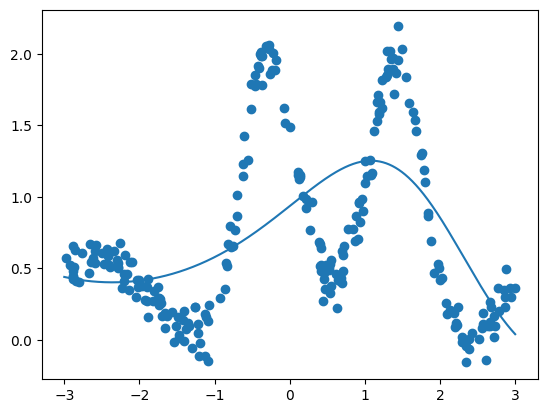

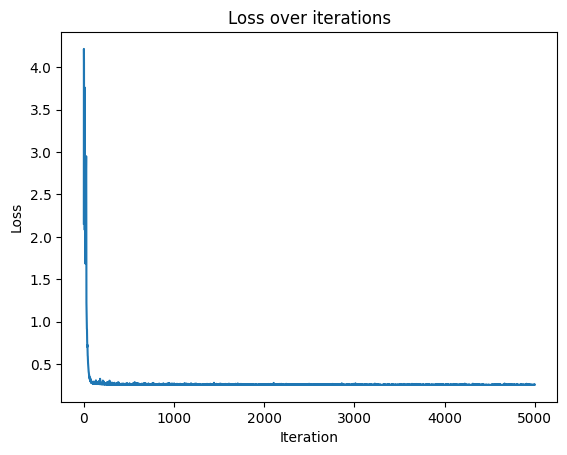

In [6]:
# Implement a selection function that iterates over the data points. It should have a few features
# 1. It should have a parameter that controls the number of data points to use
# 2. It should sequentially pass over the data points. Once it reaches the end of the data, it should shuffle the data and start over
# a few suggestions for how to do this
# 1. You can store the current index in the selection function and increment it each time the function is called
# 2. You can maintain an array of indices that you shuffle each time you reach the end of the data
# 3. One useful thing to know, in python if a class has a __call__ method, you can call the class like a function. We use this to override the () operator so that when the training loop calls the selection function
# Note that we've made the dataset divisible by powers of 2 to make it so that
# you can keep easy count of how far along the dataset you are


class SelectionFunction():
    def __init__(self, batch_size, data_size):
        self.batch_size = batch_size
        self.indices = np.arange(data_size)
        self.current_index = 0
        
    def __call__(self, x_data, y_data):
        if self.current_index + self.batch_size > len(x_data):
            np.random.shuffle(self.indices)
            self.current_index = 0
        start = self.current_index
        end = self.current_index + self.batch_size
        self.current_index += self.batch_size
        return x_data[self.indices[start:end]], y_data[self.indices[start:end]]
    
sgd_selection_func = SelectionFunction(32, x_data.shape[0])
learning_rate = 0.01
func = ScalarFunction(omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3, learning_rate)
plot_and_run(func, 5000, sgd_selection_func)
    
    

# Problem 2 - Implementing a deep network
Okay, so in the previous problem we implemented a scalar network but with a pretty bad software abstraction. Unless you figured out a nice abstraction, you probably had to laboriously write out the forward and backward pass for each layer in a fairly large chunk of code.
Now, we're going to implement a deeper network where you can't get away with hardcoding the layers. Implement a deep network with 10 layers, each with a hidden size of 100. Use the same nonlinearity in each layer. The correct software abstraction for this isn't obvious, so we'll help you with some components. 

Note, what follows is a slightly simplified version of the code in Karpathy's [micrograd project](https://github.com/karpathy/micrograd) so just giving credit where it is due. The code in that project implements something much more general and flexible and you should take a look at it if you're interested in understanding a little bit more deeply. It's only 150 lines of code and I recommend reading it!

The useful abstraction that we'll give you is the following: a `Module` class with `__call__`, `parameters`, and `zero_grad` methods. The `__call__` method should take in an input and return the output but most importantly, it should store all the info that we are going to need to compute the gradient when we do the backward pass. The `parameters` method should return a list of tensors that are part of the network. The `zero_grad` method should zero out the gradient for each parameter. Every Module will also have a `backward` method that will compute the gradients of the input. Note that this backward method will take in a `grad` argument which will represent the gradient coming from the previous layer in the backwards chain.


Loss at iteration 0: 12.652706900217826
Loss at iteration 100: 0.0006574644298235353
Loss at iteration 200: 0.000420882421977651
Loss at iteration 300: 0.00037527711726701346
Loss at iteration 400: 0.00036305961489080043
Loss at iteration 500: 0.0003652110356373459
Loss at iteration 600: 0.0003745424783203643
Loss at iteration 700: 0.0003898123290143439
Loss at iteration 800: 0.00041164935795306166
Loss at iteration 900: 0.00043771669942789
Loss at iteration 1000: 0.00046261869547673575
Loss at iteration 1100: 0.0004759321346811608
Loss at iteration 1200: 0.00049082001310876
Loss at iteration 1300: 0.0005003717167569304
Loss at iteration 1400: 0.0005064679135782551
Loss at iteration 1500: 0.0005128941954533831
Loss at iteration 1600: 0.0005189947247033792
Loss at iteration 1700: 0.0005218956245793573
Loss at iteration 1800: 0.0005225595520729416
Loss at iteration 1900: 0.0005221355608797472
Loss at iteration 2000: 0.0005207074096976062
Loss at iteration 2100: 0.0005191018889172596
Loss

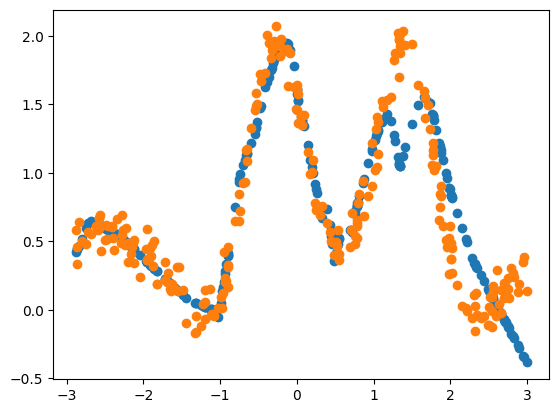

In [7]:
class MeanSquaredLoss():
    def __init__(self):
        self.loss_val = 0
    def __call__(self, y_pred, y_true):
        # TODO implement this
        return np.mean((y_pred - y_true)**2) / len(y_true)
    def grad(self, y_pred, y_true):
        # TODO implement this
        return 2 * (y_pred - y_true) / len(y_true)
    
class ReLU():
    def __call__(self, x):
        self.x = x
        return np.maximum(0, x)
    def backward(self, grad):
        # TODO implement this
        return grad * (self.x > 0)
    def zero_grad(self):
        pass
    def parameters(self):
        return []  # ReLu has no parameters

class Layer():
    def __init__(self, in_features, out_features):
        '''Initializer for the layer'''
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.random.normal(0, 1, (in_features, out_features))
        self.bias = np.random.normal(0, 1, out_features)
        self.weight_grad = np.zeros((in_features, out_features))
        self.bias_grad = np.zeros(out_features)
        
    def parameters(self):
        return [(self.weight, self.weight_grad), (self.bias, self.bias_grad)]
    
    def __call__(self, x):
        self.x = x
        return np.dot(x, self.weight) + self.bias

    def backward(self, grad):
        self.weight_grad += np.dot(self.x.T, grad)
        self.bias_grad += np.sum(grad, axis=0)
        return np.dot(grad, self.weight.T)
    
    def zero_grad(self):
        '''Set the gradients to zero'''
        self.weight_grad = np.zeros_like(self.weight)
        self.bias_grad = np.zeros_like(self.bias)
        
class Network():
    def __init__(self, layers):
        self.layers = layers
        
    def parameters(self):
        '''Returns a list of list of all the parameters in the network'''
        return [param for layer in self.layers for param in layer.parameters()]
    
    def __call__(self, x):
        '''Returns the final output of the network'''
        for layer in self.layers:
            x = layer(x)
        return x
    
    def backward(self, grad):
        '''Goes backwards through the net and alls the backward function of each layer'''
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def zero_grad(self):
        '''Goes backward through the net and calls the zero_grad function of each layer'''
        for layer in self.layers:
            layer.zero_grad()
    
# Now the last thing we need is an optimizer. This takes in the daa
# passes it through the network, computes the loss, and then
# actually updates the gradients

class SGDOptimizer():
    def __init__(self, network, loss_fn, learning_rate):
        self.network = network
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        
    def step(self, x_data, y_data):
        '''Update the parameters of the network and return the loss'''
        self.network.zero_grad()
        y_pred = self.network(x_data)
        loss = self.loss_fn(y_pred, y_data)
        grad = self.loss_fn.grad(y_pred, y_data)
        self.network.backward(grad)
        for param, grad in self.network.parameters():
            param -= self.learning_rate * grad
        return loss
        
# Now lets try this over the dataset we build before
omega_0 = 1.0
beta_0 = 1.0
omega_1 = 1.0
beta_1 = 1.0
omega_2 = 1.0
beta_2 = 1.0
omega_3 = 1.0
beta_3 = 1.0
data_size = 256
x_data = np.random.uniform(-3, 3, (data_size, 1))
y_data = f(x_data, omega_0, beta_0, omega_1, beta_1, omega_2, beta_2, omega_3, beta_3) + np.random.normal(0, 0.1, (data_size, 1))

# instantiate a network
layer1 = Layer(1, 32)
layer2 = Layer(32, 32)
layer3 = Layer(32, 1)
relu_1 = ReLU()
relu_2 = ReLU()
network = Network([layer1, relu_1, layer2, relu_2, layer3])
loss_fn = MeanSquaredLoss()
optimizer = SGDOptimizer(network, loss_fn, 0.001)

# Now lets train the network
losses = []
for i in range(3000):
    loss = optimizer.step(x_data, y_data)
    losses.append(loss)
    if i % 100 == 0:
        print(f'Loss at iteration {i}: {loss}')
        
# Now lets output a prediction
y_pred = network(x_data)
plt.figure()
plt.scatter(x_data, y_pred)
plt.scatter(x_data, y_data)

# Problem 2.2 - Changing the activation
Now that you have a working implementation, lets try swapping out the ReLU with a leaky ReLU. This is a version of the ReLU that allows a small gradient when the input is negative. This is the leaky ReLU activation function:
$$\text{leaky\_relu}(x) = \begin{cases}
x, & \text{if }\, x > 0 \\
\alpha x, & \text{otherwise}
\end{cases}$$
where $\alpha$ is a positive hyperparameter that determines how much the function leaks.
Lets try swapping out the activation function and see how it affects the convergence of the network (note, I don't expect this to have a big effect).


Loss at iteration 0: 1.8760514203879464
Loss at iteration 100: 0.001493652459650102
Loss at iteration 200: 0.0012846661014770905
Loss at iteration 300: 0.0011628375958964263
Loss at iteration 400: 0.001074860712635675
Loss at iteration 500: 0.0010106471154807469
Loss at iteration 600: 0.0009584213618960103
Loss at iteration 700: 0.0009097528678426966
Loss at iteration 800: 0.0008596790812764644
Loss at iteration 900: 0.000814336575570329
Loss at iteration 1000: 0.0007672932785615036
Loss at iteration 1100: 0.0007222712466517401
Loss at iteration 1200: 0.000679040729046066
Loss at iteration 1300: 0.0006408237128083652
Loss at iteration 1400: 0.0006071924536949619
Loss at iteration 1500: 0.0005768084685473037
Loss at iteration 1600: 0.0005492102522734569
Loss at iteration 1700: 0.0005233006763988176
Loss at iteration 1800: 0.0004991846244825188
Loss at iteration 1900: 0.00047756568624413584
Loss at iteration 2000: 0.0004566502279384342
Loss at iteration 2100: 0.00043659335348646534
Loss 

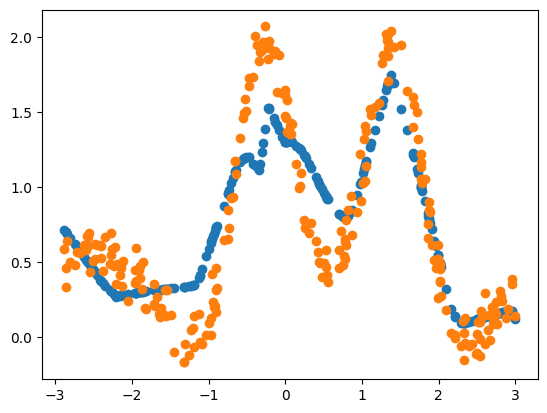

In [8]:
# TODO: Implement the leaky relu, train a model with it, and plot the results below
class LeakyReLU():
    def __init__(self, alpha):
        self.alpha = alpha
        
    def __call__(self, x):
        self.x = x
        return np.maximum(self.alpha * x, x)
    
    def backward(self, grad):
        return grad * (self.x > 0) + grad * self.alpha * (self.x <= 0)
    
    def zero_grad(self):
        pass
    
    def parameters(self):
        return []

# Now lets try this with the leaky relu
layer1 = Layer(1, 32)
layer2 = Layer(32, 32)
layer3 = Layer(32, 1)
leaky_relu = LeakyReLU(0.01)
network = Network([layer1, leaky_relu, layer2, leaky_relu, layer3])
loss_fn = MeanSquaredLoss()
optimizer = SGDOptimizer(network, loss_fn, 0.001)

# Now lets train the network
losses = []
for i in range(3000):
    loss = optimizer.step(x_data, y_data)
    losses.append(loss)
    if i % 100 == 0:
        print(f'Loss at iteration {i}: {loss}')
        
# Now lets output a prediction
y_pred = network(x_data)
plt.figure()
plt.scatter(x_data, y_pred)
plt.scatter(x_data, y_data)
    

# Problem 2.3 - Changing the optimizer
Now that you have a working implementation, lets try swapping out the optimizer. Try using the Adam optimizer instead of the SGD optimizer. Adam is a more sophisticated optimizer that uses the first and second moments of the gradient to adaptively adjust the learning rate for each parameter. You can find the Adam update rule in the lecture slides.

In [9]:
# TODO: Implement the Adam optimizer, implement the momentum optimizer
# and compare the results below
class MomentumOptimizer():
    def __init__(self, network, loss_fn, learning_rate, momentum=0.9):
        self.network = network
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocities = [np.zeros_like(param) for param, grad in self.network.parameters()]
        
    def step(self, x_data, y_data):
        '''Update the parameters of the network and return the loss'''
        self.network.zero_grad()
        y_pred = self.network(x_data)
        loss = self.loss_fn(y_pred, y_data)
        grad = self.loss_fn.grad(y_pred, y_data)
        self.network.backward(grad)
        for i, (param, grad) in enumerate(self.network.parameters()):
            self.velocities[i] = self.momentum * self.velocities[i] + (1 - self.momentum) * grad
            param -= self.learning_rate * self.velocities[i]
        return loss

class AdamOptimizer():
    def __init__(self, network, loss_fn, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.network = network
        self.loss_fn = loss_fn
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.momentums = [np.zeros_like(param) for param, grad in self.network.parameters()]
        self.velocities = [np.zeros_like(param) for param, grad in self.network.parameters()]
        self.t = 0
    
    def step(self, x_data, y_data):
        '''Update the parameters of the network and return the loss'''
        self.network.zero_grad()
        y_pred = self.network(x_data)
        loss = self.loss_fn(y_pred, y_data)
        grad = self.loss_fn.grad(y_pred, y_data)
        self.network.backward(grad)
        self.t += 1
        for i, (param, grad) in enumerate(self.network.parameters()):
            self.momentums[i] = self.beta1 * self.momentums[i] + (1 - self.beta1) * grad
            self.velocities[i] = self.beta2 * self.velocities[i] + (1 - self.beta2) * grad**2
            m_hat = self.momentums[i] / (1 - self.beta1**self.t)
            v_hat = self.velocities[i] / (1 - self.beta2**self.t)
            param -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return loss
    
# Now lets try this with the relu
layer1 = Layer(1, 32)
layer2 = Layer(32, 32)
layer3 = Layer(32, 1)
relu = ReLU()
network = Network([layer1, relu, layer2, relu, layer3])
loss_fn = MeanSquaredLoss()
adam_optimizer = AdamOptimizer(network, loss_fn, 0.001)
losses_adam = []
for i in range(3000):
    loss = adam_optimizer.step(x_data, y_data)
    losses_adam.append(loss.item())
    if i % 100 == 0:
        print(f'Loss at iteration {i}: {loss}')

layer1 = Layer(1, 32)
layer2 = Layer(32, 32)
layer3 = Layer(32, 1)
relu = ReLU()
network = Network([layer1, relu, layer2, relu, layer3])
loss_fn = MeanSquaredLoss()
momentum_optimizer = MomentumOptimizer(network, loss_fn, 0.001)
losses_momentum = []
for i in range(3000):
    loss = momentum_optimizer.step(x_data, y_data)
    losses_momentum.append(loss.item())
    if i % 100 == 0:
        print(f'Loss at iteration {i}: {loss}')
        
layer1 = Layer(1, 32)
layer2 = Layer(32, 32)
layer3 = Layer(32, 1)
relu = ReLU()
network = Network([layer1, relu, layer2, relu, layer3])
loss_fn = MeanSquaredLoss()
sgd_optimizer = SGDOptimizer(network, loss_fn, 0.001)
losses_sgd = []
for i in range(3000):
    loss = sgd_optimizer.step(x_data, y_data)
    losses_sgd.append(loss.item())
    if i % 100 == 0:
        print(f'Loss at iteration {i}: {loss}')
        
plt.figure()
plt.plot(losses_adam, label='Adam')
plt.plot(losses_sgd, label='SGD')
plt.plot(losses_momentum, label='Momentum')
# put it on log scale
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over iterations')


Loss at iteration 0: 0.42283599269884026
Loss at iteration 100: 0.006457469693367083
Loss at iteration 200: 0.0034080088210797594
Loss at iteration 300: 0.0028901028492645995
Loss at iteration 400: 0.0024072317251619055
Loss at iteration 500: 0.001910732792381077
Loss at iteration 600: 0.0014391282063030185
Loss at iteration 700: 0.0010491289852703305
Loss at iteration 800: 0.0007430534614817827
Loss at iteration 900: 0.0005255135720907136
Loss at iteration 1000: 0.000376671338285164
Loss at iteration 1100: 0.0002875458656637702
Loss at iteration 1200: 0.0002366662162798191
Loss at iteration 1300: 0.0002066318224870409
Loss at iteration 1400: 0.00018924790929088686
Loss at iteration 1500: 0.00017547651797773968
Loss at iteration 1600: 0.00016492469088373726
Loss at iteration 1700: 0.00015523375843996842
Loss at iteration 1800: 0.00014857964972767504
Loss at iteration 1900: 0.0001429270731461212
Loss at iteration 2000: 0.00013656791555042403
Loss at iteration 2100: 0.0001305089520686858

AttributeError: 'MomentumOptimizer' object has no attribute 'beta'

**Warning: your results may not exactly match mine depending on how you implemented things!**

## Problem 2.4 - Changing the initialization
Now that you have a working implementation, lets try swapping out the initialization. Try using the Kaiming initialization, discussed in class, instead of the normal distribution. This initialization sets the variance of the weights to be $2/\text{fan\_in}$ where $fan_in$ is the number of incoming connections to a unit. This is a common initialization for ReLU units. You can find the formula for the Kaiming initialization in the lecture slides.

Loss at iteration 0: 0.030115872486438208
Loss at iteration 100: 0.0010498383933898216
Loss at iteration 200: 0.0007840779280670422
Loss at iteration 300: 0.0005699045011490613
Loss at iteration 400: 0.0004097795562068549
Loss at iteration 500: 0.0003187119859647456
Loss at iteration 600: 0.00027358278928738195
Loss at iteration 700: 0.0002493001942006453
Loss at iteration 800: 0.00023266294909587184
Loss at iteration 900: 0.00022200917976438568
Loss at iteration 1000: 0.00021446603593222905
Loss at iteration 1100: 0.00020819972512744117
Loss at iteration 1200: 0.00020487314364664357
Loss at iteration 1300: 0.0002036468276110458
Loss at iteration 1400: 0.00020252644246401694
Loss at iteration 1500: 0.0002021046603258209
Loss at iteration 1600: 0.0002017777052033098
Loss at iteration 1700: 0.00020263979631155203
Loss at iteration 1800: 0.0002045729464386741
Loss at iteration 1900: 0.0002082650577918033
Loss at iteration 2000: 0.00021121582513557006
Loss at iteration 2100: 0.000208881105

Text(0.5, 1.0, 'Loss over iterations')

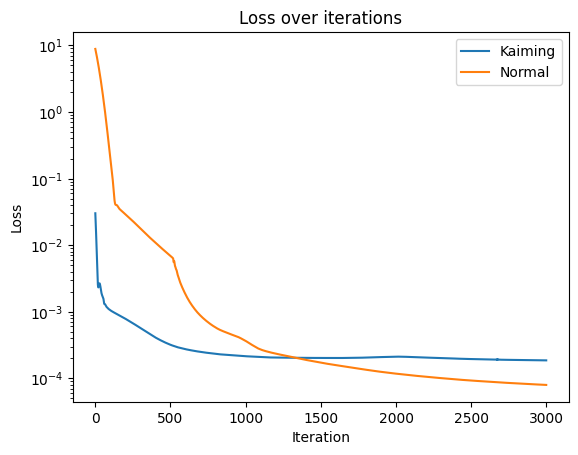

In [57]:
# TODO: implement the two networks, plot them and compare the losses
# It is probably easier to just implement one layr but have it take
# in a parameter that determines the initialization scheme
class InitalizationLayer(Layer):
    def __init__(self, in_features, out_features, initialization='Kaiming'):
        '''Initializer for the layer'''
        super().__init__(in_features, out_features)
        if initialization == 'Kaiming':
            self.weight = np.random.normal(0, np.sqrt(2/in_features), (in_features, out_features))
            self.bias = np.random.normal(0, np.sqrt(2/in_features), out_features)
        else:
            self.weight = np.random.normal(0, 1, (in_features, out_features))
            self.bias = np.random.normal(0, 1, out_features)

# implement the networks
layer1 = InitalizationLayer(1, 32, 'Kaiming')
layer2 = InitalizationLayer(32, 32, 'Kaiming')
layer3 = InitalizationLayer(32, 1, 'Kaiming')
relu = ReLU()
network = Network([layer1, relu, layer2, relu, layer3])
loss_fn = MeanSquaredLoss()
adam_optimizer = AdamOptimizer(network, loss_fn, 0.001)
losses_kaiming = []
for i in range(3000):
    loss = adam_optimizer.step(x_data, y_data)
    losses_kaiming.append(loss.item())
    if i % 100 == 0:
        print(f'Loss at iteration {i}: {loss}')

layer1 = InitalizationLayer(1, 32, 'Normal')
layer2 = InitalizationLayer(32, 32, 'Normal')
layer3 = InitalizationLayer(32, 1, 'Normal')
relu = ReLU()
network = Network([layer1, relu, layer2, relu, layer3])
loss_fn = MeanSquaredLoss()
adam_optimizer = AdamOptimizer(network, loss_fn, 0.001)
losses_normal = []
for i in range(3000):
    loss = adam_optimizer.step(x_data, y_data)
    losses_normal.append(loss.item())
    if i % 100 == 0:
        print(f'Loss at iteration {i}: {loss}')


# Plot the losses on a log plot
plt.figure()
plt.plot(losses_kaiming, label='Kaiming')
plt.plot(losses_normal, label='Normal')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over iterations')



Note that one won't obviously be better than the other and you **will not necessarily get the same results as me based on small implementation details**

## Problem 2.5 - Reimplementing everything with Torch
Now I've made your life difficult by making you implement everything from scratch. I did this for a reason, because this is the fundamental operation that we're doing and it's important to peek under the hood every now and then and see what's going on. But, going forwards, we're mostly going to be focusing on engineering so now it's time to get comfortable with PyTorch. Reimplement the scalar network and the deep network using PyTorch. 

Some useful things:
- [Pytorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html)
- [Another pytorch tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html)

**Desired output: Plot of the loss going down, plot of the predictions**



Loss at iteration 0: 1.0157538652420044
Loss at iteration 100: 0.2302074134349823
Loss at iteration 200: 0.15559600293636322
Loss at iteration 300: 0.07454188168048859
Loss at iteration 400: 0.036550719290971756
Loss at iteration 500: 0.024966876953840256
Loss at iteration 600: 0.017723264172673225
Loss at iteration 700: 0.013286782428622246
Loss at iteration 800: 0.011334279552102089
Loss at iteration 900: 0.01056661456823349
Loss at iteration 1000: 0.0102818813174963
Loss at iteration 1100: 0.010180803015828133
Loss at iteration 1200: 0.010130523703992367
Loss at iteration 1300: 0.010110781528055668
Loss at iteration 1400: 0.010105800814926624
Loss at iteration 1500: 0.010102474130690098
Loss at iteration 1600: 0.010096516460180283
Loss at iteration 1700: 0.010102522559463978
Loss at iteration 1800: 0.010092632845044136
Loss at iteration 1900: 0.01009063608944416
Loss at iteration 2000: 0.010088405571877956
Loss at iteration 2100: 0.010090630501508713
Loss at iteration 2200: 0.010086

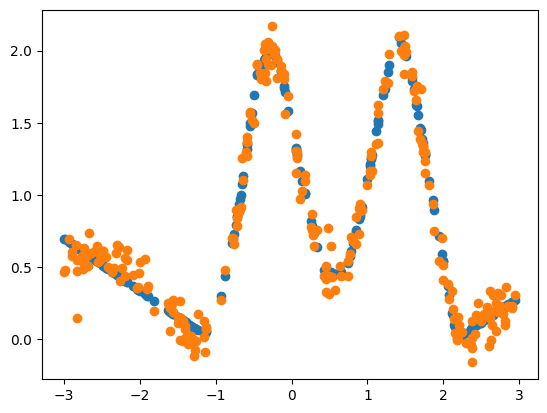

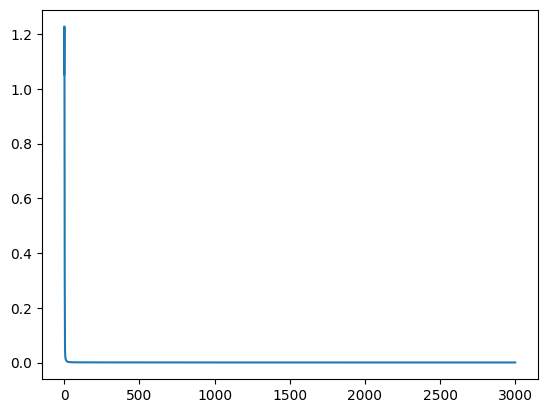

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim

x_tensor = torch.tensor(x_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.float32)

class DeepNetwork(nn.Module):
    # TODO(implement everything after here, you can use the plotting code below if you want it)
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

deep_network = DeepNetwork()
loss = nn.MSELoss()
optimizer = optim.Adam(deep_network.parameters(), lr=0.001)
for i in range(3000):
    optimizer.zero_grad()
    y_pred = deep_network(x_tensor)
    loss_val = loss(y_pred, y_tensor)
    loss_val.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'Loss at iteration {i}: {loss_val.item()}')
            
# Now lets output a prediction and plot the losses
y_pred = deep_network(x_tensor).detach().numpy()
plt.figure()
plt.scatter(x_data, y_pred)
plt.scatter(x_data, y_data)

plt.figure()
plt.plot(losses)

 

## Problem 3: Lets try a harder problem, one with some generalization challenges
So as we discussed previously, neural networks can fit noise which means sometimes they can struggle to generalize. So lets try some of the regularization methods that we have learned about. We're going to generate a noisy dataset and then split it into a train, validation and test dataset. We're going to try each of the following and see their effect on the test loss:
- L2 regularization
- Dropout
- Ensembling

**Before you do anything, we'll need scikit learn so run**
```bash
pip install scikit-learn
```

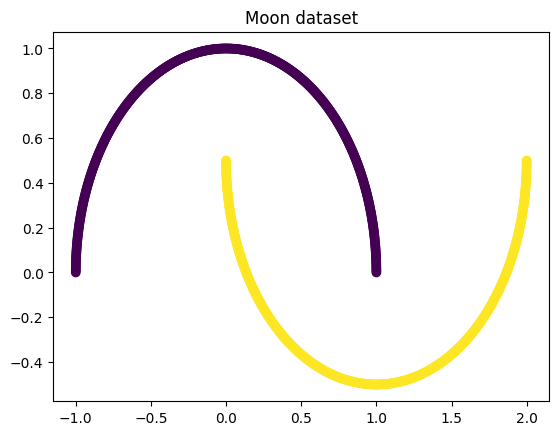

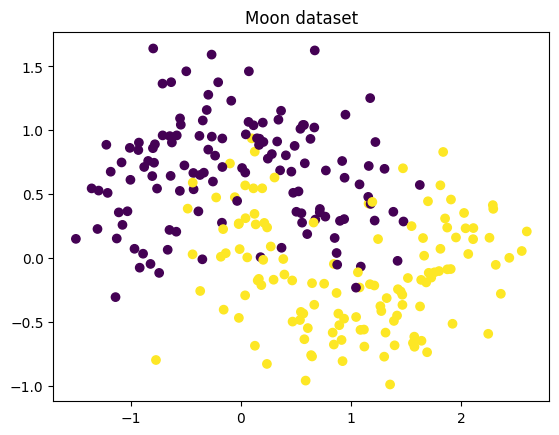

In [77]:
# Lets make the moon dataset
import torch
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

make_moons_data = make_moons(n_samples=1000, noise=0.0)
# Now plot it
plt.figure()
plt.scatter(make_moons_data[0][:, 0], make_moons_data[0][:, 1], c=make_moons_data[1])
plt.title('Moon dataset')
plt.show()

# However, we actually want to do it with a bunch of noise
make_moons_data = make_moons(n_samples=256, noise=0.3)
# Now plot it
plt.figure()
plt.scatter(make_moons_data[0][:, 0], make_moons_data[0][:, 1], c=make_moons_data[1])
plt.title('Moon dataset')
plt.show()
# Now split it into training, validation, and testing
train_size = 0.7
val_size = 0.15
test_size = 0.15
train_data = make_moons_data[0][:int(train_size * len(make_moons_data[0]))]
train_labels = make_moons_data[1][:int(train_size * len(make_moons_data[0]))]
val_data = make_moons_data[0][int(train_size * len(make_moons_data[0])):int((train_size + val_size) * len(make_moons_data[0]))]
val_labels = make_moons_data[1][int(train_size * len(make_moons_data[0])):int((train_size + val_size) * len(make_moons_data[0]))]
test_data = make_moons_data[0][int((train_size + val_size) * len(make_moons_data[0])):]
test_labels = make_moons_data[1][int((train_size + val_size) * len(make_moons_data[0])):]



## Problem 3.1 - Implement a neural network on this and visualize the train, validation and test loss
Keep in mind that for this problem, you'll need a probability at the end, not a scalar value. So, here we're going to be implementing logistic regression! Instead of just taking the sigmoid like we normally would, there's actually a torch loss that can directly take scalar outputs and applies a sigmoid to it to turn it into a probability. This loss is called the torch.nn.BCEWithLogitsLoss. Documentation for it is [here](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html). Train for long enough that you observe your validation loss actually start to go up. An alternate version is to apply the sigmoid (converting it to a probability) and then use the torch.nn.BCELoss.

A few more comments:
1. Please do not train on the entire dataset. In each optimizer step, take a subset of the data, say 32 points. This will make your training faster. You can implement this manually by shuffling your data, stepping through it in steps of 32, and then reshuffling when you reach the end. Or, you can also use [Torch Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Up to you! 
2. Use the ADAM optimizer.
3. For your network, add a function called logit that will take in a dataset and return the logit (i.e. the value before the sigmoid is applied to turn it into a probability). Some of the plotting code relies on this.
4. The losses will fluctuate a lot so I **highly** recommend smoothing them out over the entire epoch.

Average test loss: 0.6192116202452244


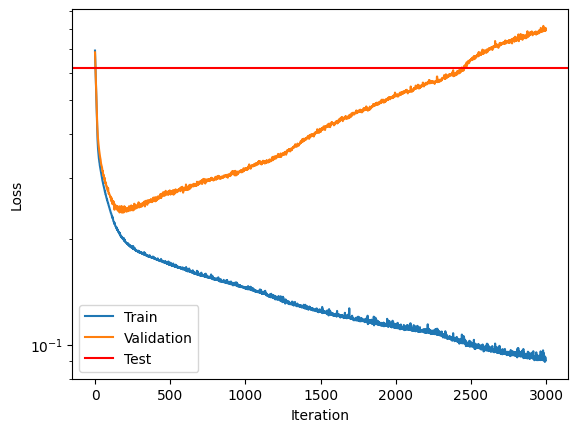

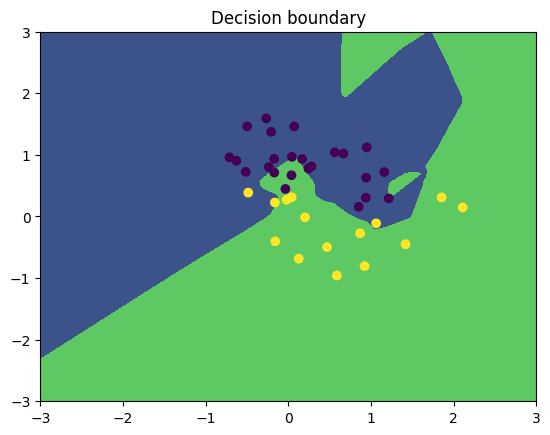

In [78]:
from torch import nn
# TODO: Set up and train a neural network on this data
train_data = torch.tensor(train_data, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)
val_data = torch.tensor(val_data, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

def visualize_results(train_losses, val_losses, deep_network):
    '''Helpful visualizer utility
    Args: train_losses: list of training losses
            val_losses: list of validation losses
            deep_network: the trained network
    '''
    # Now lets evaluate the model on the test set
    test_loader = torch.utils.data.DataLoader(list(zip(test_data, test_labels)), batch_size=32, shuffle=False)
    test_losses = []
    deep_network.eval()
    test_loss_total = 0
    total_test_samples = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            y_pred = deep_network(x_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            test_loss_total += loss.item() * x_batch.size(0)
            total_test_samples += x_batch.size(0)
    average_test_loss = test_loss_total / total_test_samples
    print(f'Average test loss: {average_test_loss}')

    # Now lets output a prediction and plot the losses
    plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    # plot the test loss as a line
    plt.axhline(average_test_loss, color='r', label='Test')
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()


    # Now lets plot the predictions and visualize the decision boundary
    x_range = np.linspace(-3, 3, 100)
    y_range = np.linspace(-3, 3, 100)
    x_mesh, y_mesh = np.meshgrid(x_range, y_range)
    xy_pairs = np.stack([x_mesh, y_mesh], axis=-1).reshape(-1, 2)
    xy_tensor = torch.tensor(xy_pairs, dtype=torch.float32)
    deep_network.eval()
    with torch.no_grad():
        predictions = deep_network(xy_tensor).numpy().reshape(100, 100)
    plt.figure()
    plt.contourf(x_mesh, y_mesh, predictions, levels=0)
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels)
    plt.title('Decision boundary')


class DeepNetwork(torch.nn.Module):
# TODO: implement everything after here
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x
    
    def logit(self, x):
        return self.forward(x)

# Now lets train the network
deep_network = DeepNetwork()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(deep_network.parameters(), lr=0.001)
train_loader = torch.utils.data.DataLoader(list(zip(train_data, train_labels)), batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(list(zip(val_data, val_labels)), batch_size=32, shuffle=False)
train_losses = []
val_losses = []
for i in range(3000):
    deep_network.train()
    train_loss_epoch = 0
    total_train_samples = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = deep_network(x_batch)
        loss = loss_fn(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * x_batch.size(0)
        total_train_samples += x_batch.size(0)
    train_losses.append(train_loss_epoch / total_train_samples)

    # Validation loop
    deep_network.eval()
    val_loss_epoch = 0
    total_val_samples = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = deep_network(x_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            val_loss_epoch += loss.item() * x_batch.size(0)
            total_val_samples += x_batch.size(0)
    val_losses.append(val_loss_epoch / total_val_samples)
    
visualize_results(train_losses, val_losses, deep_network)


## Problem 3.2 - Implement L2 regularization
Implement L2 regularization. This is done by adding a term to the loss that is proportional to the sum of the squares of the weights. This is a common form of regularization that encourages the weights to be small. The strength of the regularization is controlled by a hyperparameter $\lambda$. Implement this and see how it affects the test loss. Reuse the previous network from the previous problem and try a couple of different regularization parameters to see their effect. Try it with three different values of $\lambda$ and see if you can get the validation loss closer to the training loss. 

However, I will tell you a useful fact. The Adam optimizer has a weight_decay argument that implements L2 regularization. You're welcome to use it. The other way to implement weight decay is to note that the model has a parameters() method that returns a list of all the parameters in the model. You can then loop over these parameters and add the sum of the squares of the weights to the loss.

So, as an example for a hypothetical model called deep_model, you could do something like this:
```python
for param in deep_model.parameters():
    do something with the parameters
```

Average test loss: 0.3534412063085116


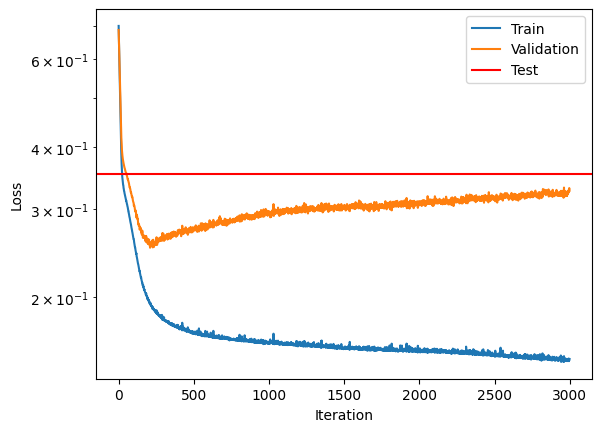

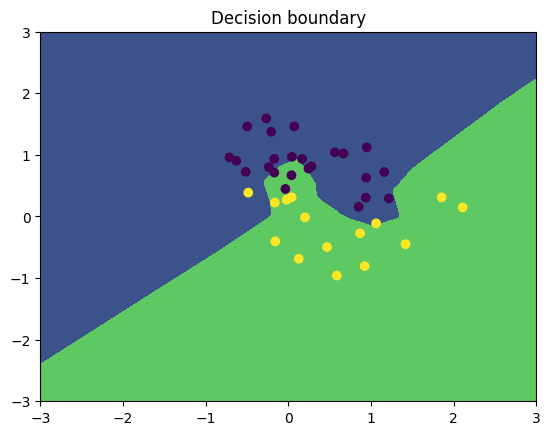

In [79]:
# Now lets train the network
deep_network = DeepNetwork()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(deep_network.parameters(), lr=0.001, weight_decay=0.001)
train_loader = torch.utils.data.DataLoader(list(zip(train_data, train_labels)), batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(list(zip(val_data, val_labels)), batch_size=32, shuffle=True)
train_losses = []
val_losses = []
for i in range(3000):
    deep_network.train()
    train_loss_epoch = 0
    total_train_samples = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = deep_network(x_batch)
        loss = loss_fn(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * x_batch.size(0)
        total_train_samples += x_batch.size(0)
    train_losses.append(train_loss_epoch / total_train_samples)

    # Validation loop
    deep_network.eval()
    val_loss_epoch = 0
    total_val_samples = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = deep_network(x_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            val_loss_epoch += loss.item() * x_batch.size(0)
            total_val_samples += x_batch.size(0)
    val_losses.append(val_loss_epoch / total_val_samples)
# Use this to visualize the results
visualize_results(train_losses, val_losses, deep_network)

## Problem 3.3 - Implement dropout
Implement dropout. This is a form of regularization that randomly sets a fraction of the activations to zero. This can be implemented in PyTorch using the torch.nn.Dropout layer. This layer takes in a single argument, which is the probability that a neuron is set to zero. Note that this is a function, so you apply it to an input or a hidden layer in the forward method so you'll have to modify the network you have.

**Important warning**: While you use dropout during training, you may not want to use it at test-time. Dropout is intended as a training-time regularization, but there's not an obvious reason to apply it after you're done training. So, you'll want to turn off dropout during test-time. You can do this by calling `model.eval()` on your model. This will set the model to evaluation mode and turn off dropout. You can then call `model.train()` to turn dropout back on.

Average test loss: 0.2743847041557997


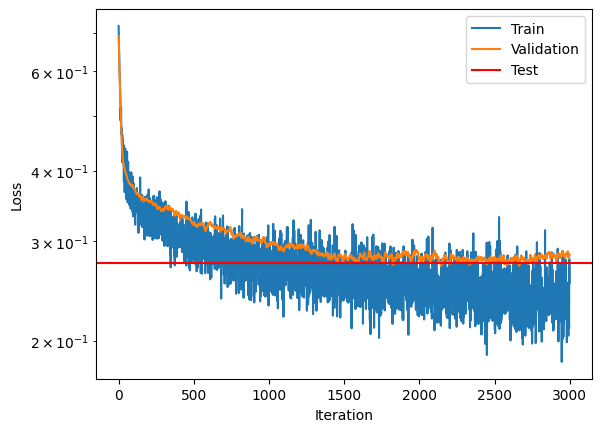

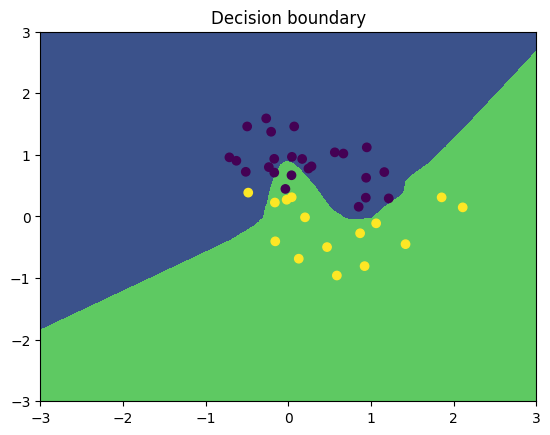

In [81]:
class DropoutNetwork(torch.nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.layer1 = nn.Linear(2, 32)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(32, 32)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.layer3(x)
        return x
    
    def logit(self, x):
        return self.forward(x)
    
deep_network = DropoutNetwork()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(deep_network.parameters(), lr=0.001, weight_decay=0.001)
train_loader = torch.utils.data.DataLoader(list(zip(train_data, train_labels)), batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(list(zip(val_data, val_labels)), batch_size=32, shuffle=True)
train_losses = []
val_losses = []
for i in range(3000):
    deep_network.train()
    train_loss_epoch = 0
    total_train_samples = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = deep_network(x_batch)
        loss = loss_fn(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * x_batch.size(0)
        total_train_samples += x_batch.size(0)
    train_losses.append(train_loss_epoch / total_train_samples)

    # Validation loop
    deep_network.eval()
    val_loss_epoch = 0
    total_val_samples = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = deep_network(x_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            val_loss_epoch += loss.item() * x_batch.size(0)
            total_val_samples += x_batch.size(0)
    val_losses.append(val_loss_epoch / total_val_samples)

# Use this to visualize the results
visualize_results(train_losses, val_losses, deep_network)

## Problem 3.4 - Ensembling
This is really one of the most powerful tools in the toolbox and is pretty much always going to give you an improvement (although it comes at a serious price of having to train and keep around multiple models!) The idea is that you train multiple models on the same dataset and then average their predictions. There's a couple of ways you could do this:
1. You could train multiple models on the same dataset and then average their predictions. This is the simplest way to do it.
2. You could train multiple models on different slices of the train dataset. 

**Watch out**: each model will need its own optimizer

In the end, you'll want to write a class that takes in a list of models and then averages their predictions. This class should have a `forward` method that takes in an input and returns the mode of the model predictions.

In [96]:
num_models = 5
models = [DeepNetwork() for _ in range(num_models)]
optimizers = [optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) for model in models]
class EnsembleNetwork():
    def __init__(self, models):
        self.models = models
        
    def __call__(self, x):
        return torch.mean(torch.stack([model(x) for model in self.models], dim=0), dim=0)
    
    def logit(self, x):
        return self(x)
    
    def eval(self):
        for model in self.models:
            model.eval()

train_losses = []
val_losses = []
for deep_network, optimizer in zip(models, optimizers):
    train_losses.append([])
    val_losses.append([])
    for i in range(2000):
        deep_network.train()
        train_loss_epoch = 0
        total_train_samples = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = deep_network(x_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item() * x_batch.size(0)
            total_train_samples += x_batch.size(0)
        train_losses[-1].append(train_loss_epoch / total_train_samples)

        # Validation loop
        deep_network.eval()
        val_loss_epoch = 0
        total_val_samples = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                y_pred = deep_network(x_batch)
                loss = loss_fn(y_pred, y_batch.unsqueeze(1))
                val_loss_epoch += loss.item() * x_batch.size(0)
                total_val_samples += x_batch.size(0)
        val_losses[-1].append(val_loss_epoch / total_val_samples)

final_network = EnsembleNetwork(models)
# Now we probably need to average the losses
print(np.array(train_losses).shape)
train_losses = np.mean(train_losses, axis=0)
val_losses = np.mean(val_losses, axis=0)
# Use this to visualize the results
visualize_results(train_losses, val_losses, final_network)